# Discrete Key-Value Bottleneck: A Simple Learning Setting Motivating the Method

We consider a 2D input feature classification problem for 8
classes, where the training data is not i.i.d. but changes over
four stages. In each stage, we sample 100
examples of two classes for 1000 training steps, using gradient descent to update the weights, then move on to two new
classes for the next 1000 steps. The input features of each
class follow spatially separated normal distributions.



In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [32]:
NUM_CLASSES = 8
INPUT_DIM = 2
OUTPUT_DIM = 8
SAMPLES_PER_CLASS = 100

NUM_EPOCHS = 1000

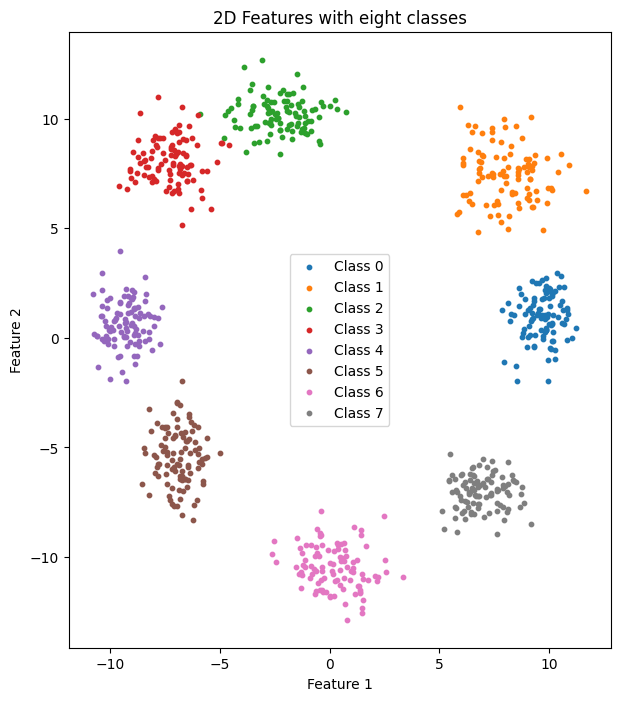

In [85]:
df = pd.read_csv("Toy Synthetic Dataset.csv")
df.drop(columns="Unnamed: 0", inplace=True)

# scaler = MinMaxScaler()
# df[['Feature_1', 'Feature_2']] = scaler.fit_transform(df[['Feature_1', 'Feature_2']])

plt.figure(figsize=(8, 8))
for i in range(NUM_CLASSES):
    plt.scatter(df[df["Labels"] == i]["Feature_1"], df[df["Labels"] == i]["Feature_2"], 
                label=f'Class {i}', s=10)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Features with eight classes')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [86]:
X = torch.tensor(df.drop(columns="Labels").to_numpy()).float()
y = torch.tensor(df["Labels"].to_numpy())

### **Function to display the decision boundaries**

In [98]:
def plot_datapoints_and_decision_boundary(model, X, y, lim=15, resolution=0.01, h=0.1):
    
    model.eval()    
    xx, yy = np.meshgrid(np.arange(-lim, lim, h), np.arange(-lim, lim, h))
    
    fig, ax = plt.subplots()
    
    input = np.c_[xx.ravel(), yy.ravel()]

    Z = model(torch.tensor(input).float()).detach()
    
    Z = torch.argmax(Z, dim=1)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z.numpy(), cmap="viridis", alpha=0.5)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="jet", s=10)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    plt.show()


In [99]:
loss_criterion = nn.CrossEntropyLoss()

def train_incrementally(num_epochs, X, y, model, loss_criterion, optimizer, scheduler=None):
    
    delta = int(X.shape[0] / 2)
    losses = []
    for i in range(int(NUM_CLASSES/2)):
        X_train = torch.vstack([X[i * SAMPLES_PER_CLASS : (i + 1) * SAMPLES_PER_CLASS], 
                                X[i * SAMPLES_PER_CLASS + delta: (i + 1) * SAMPLES_PER_CLASS + delta]]).float()
        
        y_train = torch.vstack([y[i * SAMPLES_PER_CLASS : (i + 1) * SAMPLES_PER_CLASS], 
                                y[i * SAMPLES_PER_CLASS + delta: (i + 1) * SAMPLES_PER_CLASS + delta]])
        y_train = y_train.reshape(2 * SAMPLES_PER_CLASS)
        print(f"Classes being trained on are: {y_train.unique()}")
        
        dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
        
        for epoch in range(num_epochs):
            for inputs, labels in train_loader:

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                losses.append(loss.item())

                optimizer.zero_grad() 
                loss.backward() 
                optimizer.step()  
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

        print(f"Training period { i + 1 } completed")
        
        plot_datapoints_and_decision_boundary(model, X_train.detach().numpy(), y_train.detach().numpy())

In [100]:
def init_weights_to_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias) 
            
def init_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [101]:
class LinearProbe(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_layer = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        z = self.linear_layer(x)
        return z

Classes being trained on are: tensor([0, 4])
Epoch 1/1000, Loss: 0.0219
Epoch 101/1000, Loss: 0.0002
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0001
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0001
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 1 completed


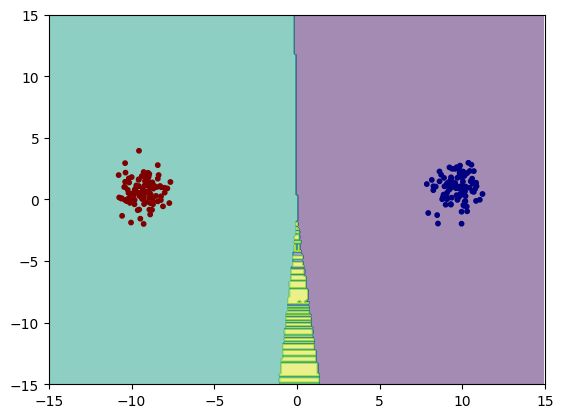

Classes being trained on are: tensor([1, 5])
Epoch 1/1000, Loss: 0.0131
Epoch 101/1000, Loss: 0.0002
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0001
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0001
Epoch 701/1000, Loss: 0.0001
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 2 completed


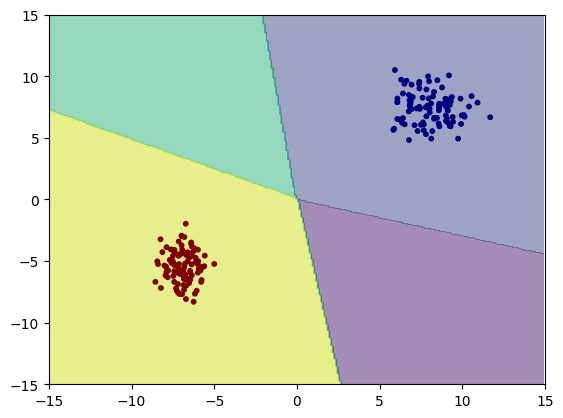

Classes being trained on are: tensor([2, 6])
Epoch 1/1000, Loss: 0.0176
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0002
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0001
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 3 completed


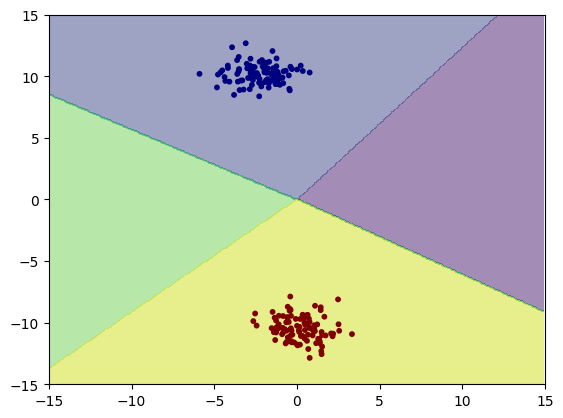

Classes being trained on are: tensor([3, 7])
Epoch 1/1000, Loss: 0.0172
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0001
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 4 completed


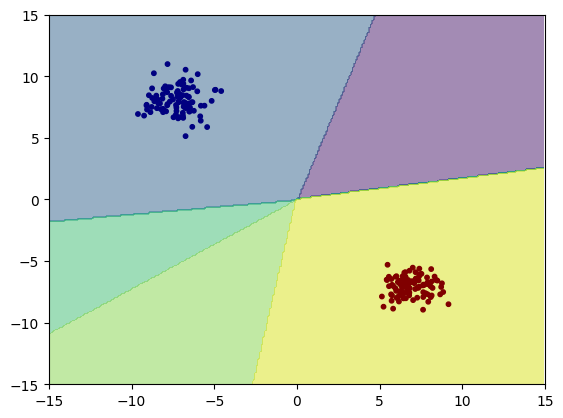

In [108]:
linear_probe = LinearProbe(INPUT_DIM, NUM_CLASSES)
optimizer = optim.SGD(linear_probe.parameters(), lr=0.05)

linear_probe.apply(init_weights_to_zero)
train_incrementally(NUM_EPOCHS, X, y, linear_probe, loss_criterion, optimizer)

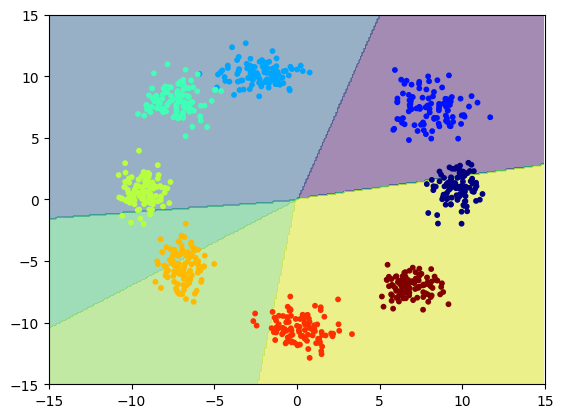

In [103]:
plot_datapoints_and_decision_boundary(linear_probe, X, y)

In [104]:
class NaiveMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.hidden_layer(x)
        activations = self.relu(h)
        z = self.output_layer(activations)
        return z

Classes being trained on are: tensor([0, 4])
Epoch 1/1000, Loss: 0.0058
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 1 completed


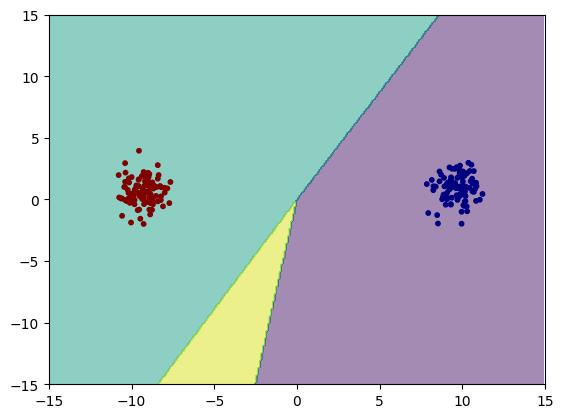

Classes being trained on are: tensor([1, 5])
Epoch 1/1000, Loss: 0.0129
Epoch 101/1000, Loss: 0.0001
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 2 completed


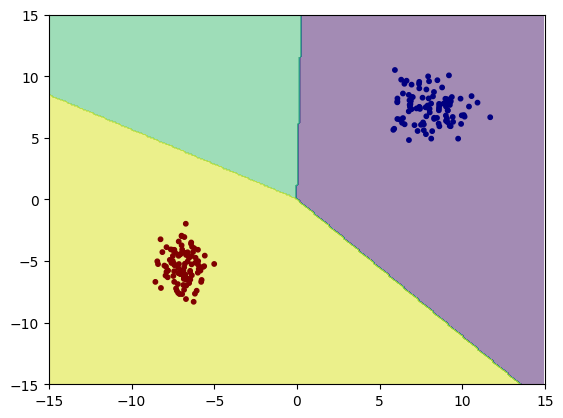

Classes being trained on are: tensor([2, 6])
Epoch 1/1000, Loss: 0.0005
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 3 completed


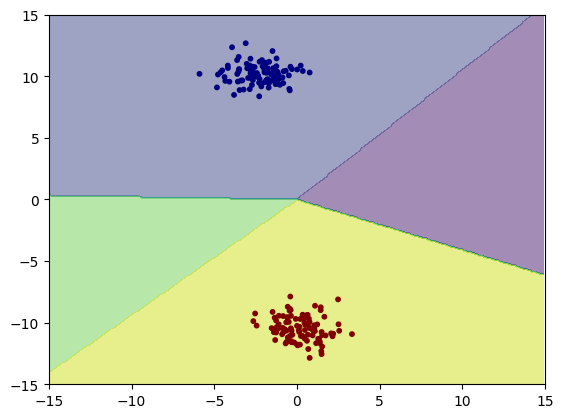

Classes being trained on are: tensor([3, 7])
Epoch 1/1000, Loss: 0.0006
Epoch 101/1000, Loss: 0.0000
Epoch 201/1000, Loss: 0.0000
Epoch 301/1000, Loss: 0.0000
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Training period 4 completed


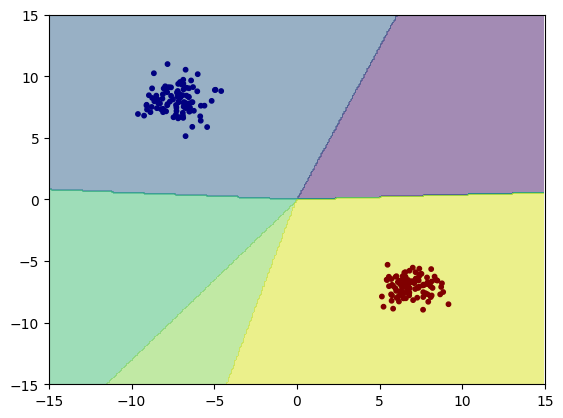

In [105]:
naiveMLP32 = NaiveMLP(INPUT_DIM, 32, NUM_CLASSES)
optimizer = optim.SGD(naiveMLP32.parameters(), lr=0.01)

naiveMLP32.apply(init_weights_kaiming)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_incrementally(NUM_EPOCHS, X, y, naiveMLP32, loss_criterion, optimizer, scheduler)

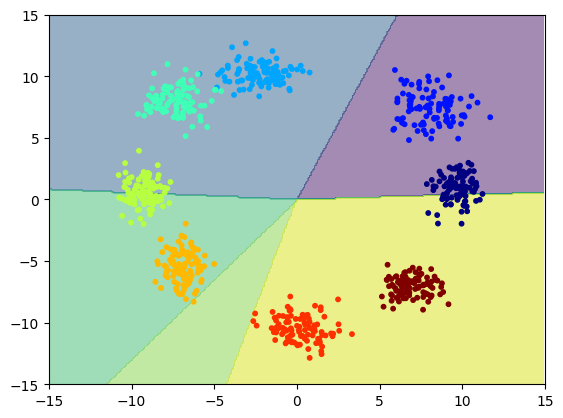

In [106]:
plot_datapoints_and_decision_boundary(naiveMLP32, X, y)